In [2]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensemble modeli için yükleme
mlp_model = load_model("models_daily/mlp_model_tuned.keras")
lgbm_model = joblib.load("models_daily/lgbm_model.pkl")
rf_model   = joblib.load("models_daily/rf_model.pkl")
ensemble_weights = joblib.load("models_daily/ensemble_weights.pkl")

# Scalerlar
scaler = joblib.load("models_daily/scaler.pkl")
y_scaler = joblib.load("models_daily/y_scaler.pkl")


In [3]:
X_test = joblib.load("models_daily/X_test.pkl")
X_test_scaled = joblib.load("models_daily/X_test_scaled.pkl")
y_test = joblib.load("models_daily/y_test.pkl")

y_true = y_test.values.reshape(-1)

In [4]:
# MLP scaled
mlp_preds_scaled = mlp_model.predict(X_test_scaled).reshape(-1)
mlp_preds = y_scaler.inverse_transform(mlp_preds_scaled.reshape(-1, 1)).reshape(-1)

# Tree modeller
lgbm_preds = lgbm_model.predict(X_test).reshape(-1)
rf_preds   = rf_model.predict(X_test).reshape(-1)

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [5]:
w1, w2, w3 = ensemble_weights

ensemble_preds = w1 * mlp_preds + w2 * lgbm_preds + w3 * rf_preds


In [6]:
def evaluate_model(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    
    print(f"\n{name} Test Performansı:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"SMAPE: {smape:.2f}%")
    print(f"Corr : {corr:.4f}")


In [7]:
evaluate_model(y_true, mlp_preds, name="MLP")
evaluate_model(y_true, lgbm_preds, name="LightGBM")
evaluate_model(y_true, rf_preds, name="Random Forest")
evaluate_model(y_true, ensemble_preds, name="Ensemble")



MLP Test Performansı:
MAE  : 4.26
RMSE : 5.19
R²   : -0.0314
MAPE : 6.14%
SMAPE: 6.38%
Corr : 0.6949

LightGBM Test Performansı:
MAE  : 3.09
RMSE : 3.76
R²   : 0.4585
MAPE : 4.45%
SMAPE: 4.58%
Corr : 0.8309

Random Forest Test Performansı:
MAE  : 4.17
RMSE : 4.94
R²   : 0.0683
MAPE : 5.94%
SMAPE: 6.18%
Corr : 0.7876

Ensemble Test Performansı:
MAE  : 3.09
RMSE : 3.76
R²   : 0.4585
MAPE : 4.45%
SMAPE: 4.58%
Corr : 0.8309


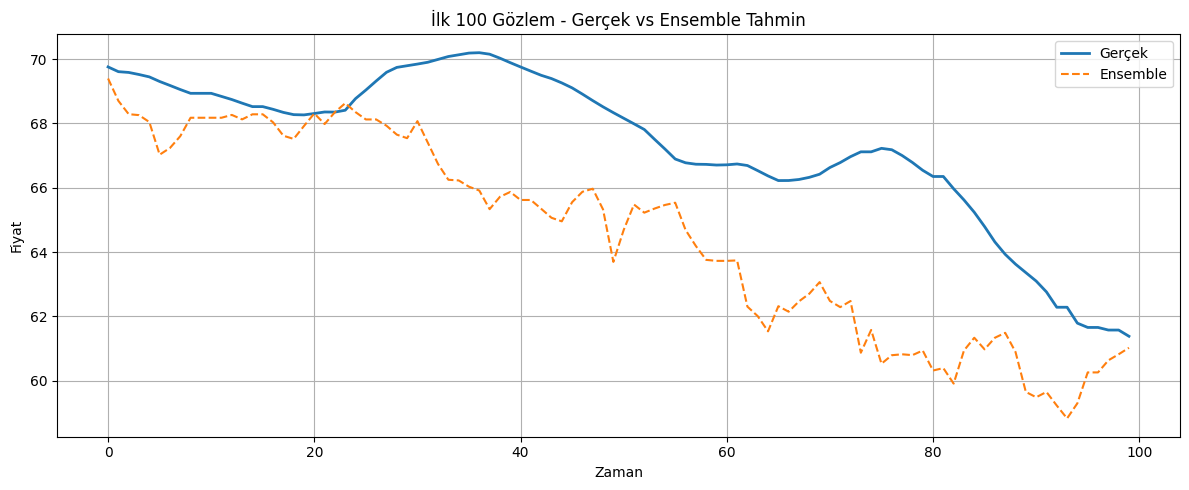

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_true[:100], label="Gerçek", linewidth=2)
plt.plot(ensemble_preds[:100], label="Ensemble", linestyle="--")
plt.title("İlk 100 Gözlem - Gerçek vs Ensemble Tahmin")
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test setinde yapılan değerlendirmelerde LightGBM modeli en düşük hata oranlarına ulaşmış ve diğer modellere göre çok daha tutarlı sonuçlar üretmiştir. Ensemble modeli kurulmuş olsa da, ağırlık optimizasyonu sonucunda sadece LightGBM modeline ağırlık verilmiş (diğer modellerin ağırlıkları sıfır kalmıştır).

Bu durum, LightGBM’in veri yapısıyla en iyi uyumu yakaladığını ve tahmin doğruluğu açısından öne çıktığını gösteriyor. Model sadece düşük hata üretmekle kalmamış, aynı zamanda günlük bazda değişimleri de başarılı şekilde takip edebilmiştir.

Sonuç olarak, bu günlük tahmin probleminde LightGBM modeli en güvenilir seçenek olarak öne çıkmış ve final tahminler için tercih edilmiştir.